# Learnit...의 shapenet.ipynb 파일을 기반으로 작성

### 이 파트는 수정된게 거의 없습니다. `CUDA_VISIBLE_DEVICES`만 바꿔주세요.

In [62]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [63]:
#!pip3 install jax

In [64]:
#!python3 -m pip install /home/stella/jaxlib-0.1.66+cuda101-cp37-none-manylinux2010_x86_64.whl

In [65]:
#!pip3 install -q optax
#!pip3 install -q git+https://github.com/deepmind/dm-haiku
#!pip3 install livelossplot

In [66]:
import sys
sys.path.append("/home/stella/anaconda3/envs/nerf/lib/python3.7/site-packages")

In [67]:
from functools import partial
import jax # jax==0.1.67 / jaxlib==0.1.55
from jax import random, grad, jit, vmap, flatten_util, nn
from jax.experimental import optix
from jax.config import config
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2

import imageio
import json
import pickle
from time import time

rng = jax.random.PRNGKey(42)

* 다음 명령어로 설치  
pip install --upgrade jax==0.1.77 jaxlib==0.1.64+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [3]:
# ## pseudo image generation
# num_scene = 5
# scene_path =[os.path.join(DATA_PATH, "scene"+str(scene), "train") for scene in range(num_scene)]

# with open(os.path.join(DATA_PATH, 'transforms_'+'train'+'.json'), 'r') as fp:
#     meta = json.load(fp)

# imgs = []
# bkgds = []
# poses = []
# origpath = os.path.join(DATA_PATH, "original", "train")

# for ii in range(5):
#     # img0 = imageio.imread(os.path.join(scene_path[0], 'r_0.png')) # to get H, W
#     # H, W = img0.shape[0]//down, img0.shape[1]//down
#     os.makedirs(scene_path[ii], exist_ok=True)
#     for idx in np.arange(len(meta['frames'])):
#         frame = meta['frames'][idx]
#         origname = os.path.join(origpath, 'r_'+str(idx)+'.png')
#         img = imageio.imread(origname)

#         img1 = img.astype('float64')
#         img1[img1[...,3]!=0.,0:3] *= (1 - 0.1*ii)
#         img1 = img1.astype('uint8')
#         fname = os.path.join(scene_path[ii], 'r_'+str(idx)+'.png')
#         imageio.imwrite(fname, img1)

# Data

* data를 불러오는 함수를 작성하였습니다. 데이터들은 모두 각각 `train` 폴더에 넣어놓았습니다.

즉, `DATA_PATH` 안에 scene0 scene1 scene2 scene3 scene4가 있으며 각각의 폴더에 `train`폴더를 만들고 거기에 200개의 png파일을 집어넣었습니다.


In [68]:
print(os.getcwd())

/home/stella/project_iNeRF


['/mnt/hdd1/stella/inerf/new_data/scene0/train', '/mnt/hdd1/stella/inerf/new_data/scene1/train', '/mnt/hdd1/stella/inerf/new_data/scene2/train', '/mnt/hdd1/stella/inerf/new_data/scene3/train', '/mnt/hdd1/stella/inerf/new_data/scene4/train', '/mnt/hdd1/stella/inerf/new_data/scene5/train']
(100, 200, 200, 3)
[[-0.99999994  0.          0.          0.        ]
 [ 0.         -0.73411     0.6790306   2.73726   ]
 [ 0.          0.67903066  0.7341099   2.9592917 ]
 [ 0.          0.          0.          1.        ]]
[200, 200, DeviceArray(69.44444, dtype=float32)]


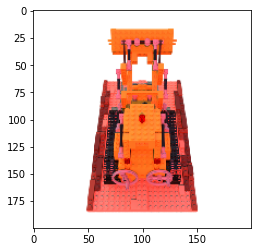

In [69]:
DATA_PATH = '/mnt/hdd1/stella/inerf/new_data' # Update
# 이 폴더에 scene0 scene1 scene2 scene3 scene4가 있다고 가정...

import json
import imageio
import cv2

def load_nerf_synthetic(scene_path, type="test", down=4):
    # h,w,f = 800, 800, 1111.11
    with open(os.path.join(DATA_PATH, 'transforms_'+type+'.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    img0 = imageio.imread(os.path.join(scene_path, '0.png')) # to get H, W
    H, W = img0.shape[0]//down, img0.shape[1]//down
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(scene_path, str(idx)+'.png')
        try:
            imgs.append(cv2.resize(imageio.imread(fname),(H,W)))
            poses.append(np.array(frame['transform_matrix']))
        except:
            continue
    focal = .5 * W / np.tan(.5 * camera_angle_x)/down
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

num_scene = 6
train_exs =[os.path.join(DATA_PATH, "scene"+str(scene), "train") for scene in range(num_scene)]
# test_exs =[os.path.join(DATA_PATH, "scene"+str(scene), "test") for scene in range(num_scene)]
print(train_exs)
imgs, poses, hwf = load_nerf_synthetic(scene_path=train_exs[0], type="test", down=4) # scene0, scene1, scene2 ...

plt.imshow(imgs[0])
print(imgs.shape)
print(poses[0])
print(hwf)

# NeRF Model and Rendering

* 여기서는 크게 달라진게 없습니다. `Model`에 있는 `self.depth`를 6을 8로 바꾼 정도?

In [70]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1))
get_ray_batch = jax.vmap(get_rays, in_axes=[None, None, None, 0], out_axes=1)

In [71]:
def render_rays(rnd_input, model, params, rays, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays
    
    near = 2
    far = 6

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = np.reshape(pts, [-1,3])
        
    raw = model.apply(params, pts_flat)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e-3], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2)
    acc_map = np.sum(weights, -1)    
    rgb_map = rgb_map + (1.-acc_map[...,None]) # white background 
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, rays, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, rays, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 4, 5, 6))

def render_fn(rnd_input, model, params, rays, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, rays[:,i:i+chunk], rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [72]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 8 #6
        self.use_viewdirs = False
                
    def __call__(self, coords, view_dirs=None):
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs = None
            viewdirs = np.repeat(viewdirs[...,None,:], coords.shape[-2], axis=-2)
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

# Meta Train

* batch_size는 줄일수록 빨리집니다 (왜냐면 한번에 사용할 ray의 갯수라서)

* load_nerf_synthetic() 함수를 만들어서 사용하였습니다. 그냥 lego 데이터를 가져오는 함수입니다.

* `train_exs` 중에 `train_exs[2]`를 test data로 사용하고 나머지를 train 용도로 사용합니다.

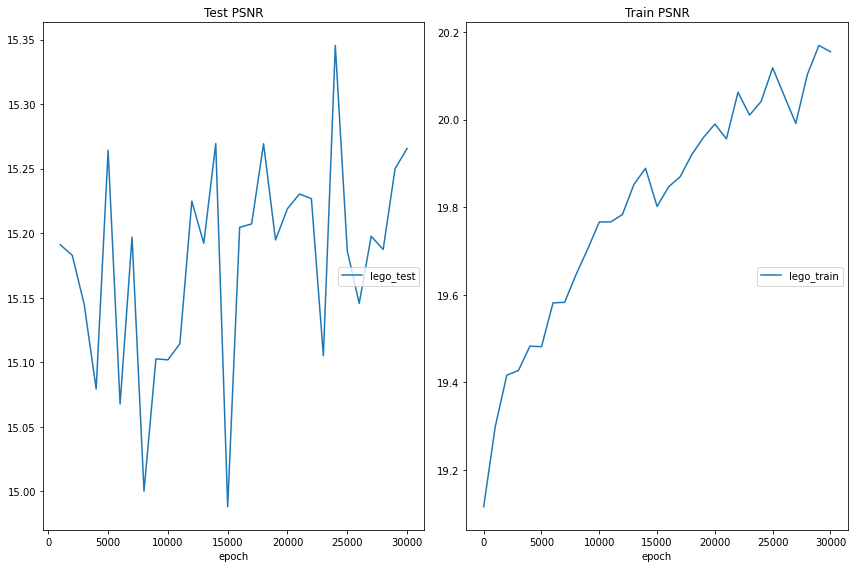

Test PSNR
	lego_test        	 (min:   14.988, max:   15.345, cur:   15.266)
Train PSNR
	lego_train       	 (min:   19.116, max:   20.169, cur:   20.155)


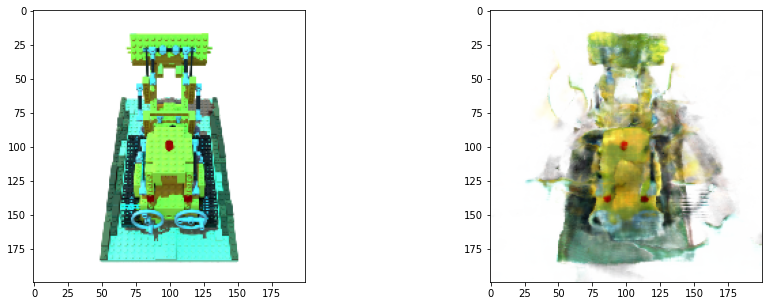

In [73]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

exp_name = 'lego'
max_iters = 30001
batch_size = 128

num_views = 100
test_time_views = 2

inner_update_steps = 32
inner_step_size = .5
lr = 5e-4

checkpoint_dir = 'checkpoints/checkpoints_lego/'
os.makedirs(checkpoint_dir, exist_ok=True)

N_samples = 128

checkpoint_file = checkpoint_dir + 'lego_10000.pkl'

model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))
#params = model.init(rng, np.ones((1,3)))
with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

test_inner_steps = 128*128 * 4// batch_size

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

# update inner model network weights with once step of sgd
@jit
def single_step(rng, images, rays, params, idx):
    def sgd(param, update):
        return param - inner_step_size * update

    def loss_fn(params, rng_inputs):
        idx = random.randint(rng_inputs[0], shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]

        g = render_rays(rng_inputs[1], model, params, rays_sub, N_samples, rand=True)
        return mse_fn(g, image_sub)

    rng, *rng_inputs = jax.random.split(rng, 3)
    loss, grad = jax.value_and_grad(loss_fn)(params, rng_inputs)
    params = jax.tree_multimap(sgd, params, grad)
    return rng, params, loss

# update inner model network weights inner_update_steps number of times
def update_network_weights(rng, images, rays, params):
    for _ in range(inner_update_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
    return rng, params, loss

# update meta model weights based on trained inner model weights
def update_model(rng, params, opt_state, images, rays):
    rng, new_params, model_loss = update_network_weights(rng, images, rays, params)

    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss

# train meta model inner_steps number of times to evaluate meta parameters
def update_network_weights_test(rng, images, rays, params, inner_steps):
    lowest_loss = 1e7
    for _ in range(inner_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
        if loss < lowest_loss:
            lowest_loss = loss
    return rng, params, lowest_loss


opt = optix.adam(lr)
opt_state = opt.init(params)

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0
train_psnrs = []
rng = jax.random.PRNGKey(0)

train_size = len(train_exs)
test_psnrs = []

images_save = []
poses_save = []
hwf_save = []
for tr_i in [0,1,3,4,5]:
    images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[tr_i], type="test", down=4)
    images_save.append(images)
    poses_save.append(poses)
    hwf_save.append(hwf)

prevtime = time()
for step in range(max_iters):
    try:
        rng, rng_input = jax.random.split(rng)
        img_idx = random.randint(rng, shape=(1,), minval=0, maxval=train_size-1)
        # images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[img_idx[0]], type="train", down=4)
        # images = images[:num_views]
        # poses = poses[:num_views]
        images = images_save[img_idx[0]][:num_views]
        poses = poses_save[img_idx[0]][:num_views]
        hwf = hwf_save[img_idx[0]]
    except:
        print("error at ", step)
        continue
    images = np.reshape(images, (-1,3))

    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, images, rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step % 100 == 0:
        currtime = time()
        print(currtime-prevtime)
        prevtime = currtime
        print(step)
    if step % 1000 == 0 and step != 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(5):
            images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[2], type="test", down=4) # middle data
            test_holdout_images, test_images = np.split(images, [75], axis=0)
            test_holdout_poses, test_poses = np.split(poses, [75], axis=0)

            test_rays = get_ray_batch(hwf[0], hwf[1], hwf[2], test_poses)
            
            test_images = test_images[:test_time_views]
            test_rays = test_rays[:test_time_views]

            test_images = np.reshape(test_images, (-1,3))
            test_rays = np.reshape(test_rays, (2,-1,3))
            rng, test_params, test_inner_loss = update_network_weights_test(rng, test_images, test_rays, params, test_inner_steps)

            test_holdout_rays = get_rays(hwf[0], hwf[1], hwf[2], test_holdout_poses[0])
            test_result = np.clip(render_fn(rng, model, test_params, test_holdout_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_holdout_images[0], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_holdout_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))

In [74]:
!ls checkpoints/checkpoints_lego

lego_10000.pkl	lego_20000.pkl	lego_30000.pkl


# 여기서부터는 테스트!!!

## function 정의
* 여기서는 `train_exs[2]`를 사용합니다. (load_nerf_synthetic() 함수) 이것은 임의로 정하였습니다.

In [47]:
def train_single_model(max_iters, rng, num_views=25, lr=1e-4, batch_size=64, N_samples=128, init_params=None, image_idx=0):

    model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

    if init_params !=None:
        params = init_params
    else:
        params = model.init(rng, np.ones((1,3)))

    opt = optix.sgd(lr)
    opt_state = opt.init(params)

    mse_fn = jit(lambda x, y: np.mean((x - y)**2))
    psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

    @jit
    def update_model(rng, params, opt_state, image, rays):
        rng, rng_inputs = jax.random.split(rng)
        def loss_model(params):
            g = render_rays(rng_inputs, model, params, rays, N_samples, rand=True, )
            return mse_fn(g, image)
        model_loss, model_grad = jax.value_and_grad(loss_model, argnums=0)(params)
        updates, opt_state = opt.update(model_grad, opt_state)
        params = optix.apply_updates(params, updates)
        return rng, params, opt_state, model_loss

    images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[2], type="test", down=4)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)

    images = images[:num_views]
    poses = poses[:num_views]
    
    H, W, focal = hwf
    rays = get_ray_batch(H, W, focal, poses)

    images_ = images
    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    for step in range(max_iters):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=(images.shape[0]))
        train_image = images[idx,:]
        train_rays = rays[:,idx,:]

        rng, params, opt_state, loss = update_model(rng, params, opt_state, train_image, train_rays)

    return params, images_


## 학습한 Checkpoint 로드하기

In [48]:
# checkpoint_file = '/mnt/disk2/JYChung/dataset/metaNeRF/checkpoints/shapenet/car_meta_params_25_view_train.pkl'
checkpoint_file = './checkpoints/checkpoints_lego/lego_10000.pkl'

with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

## 테스트할 데이터 및 간단하 테스트

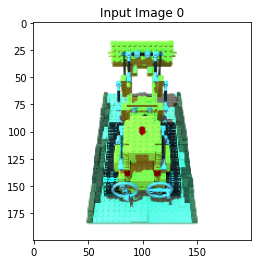

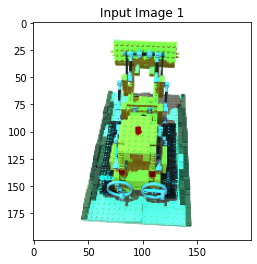

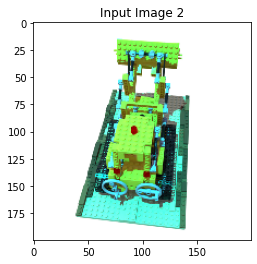

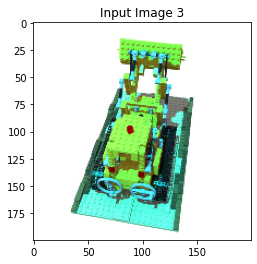

In [52]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(4):
    images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[2], type="test", down=4)
    
    plt.imshow(images[i])
    plt.title('Input Image '+str(i))
    plt.show()

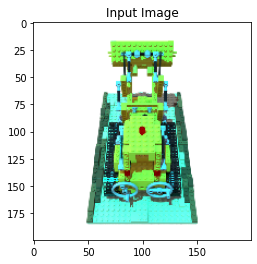

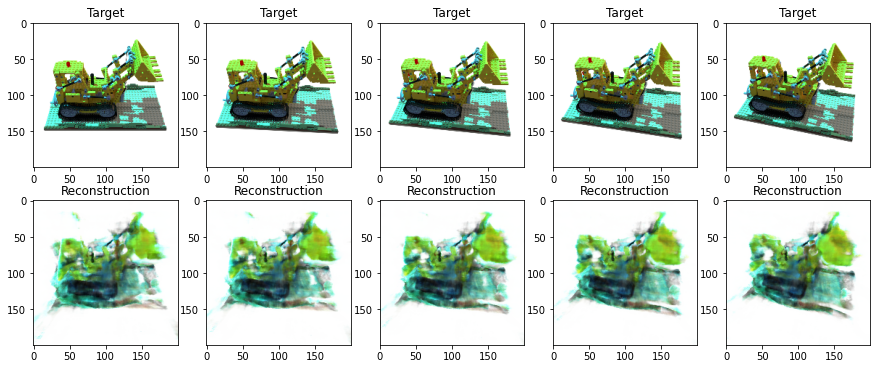

In [53]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(1):
    test_params, sup_images = train_single_model(max_iters, rng, num_views=num_views, lr=lr, init_params=params, image_idx=i)
    
    load_nerf_synthetic(scene_path=train_exs[2], type="test", down=4)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if num_views == 1:
        plt.imshow(images[0])
        plt.title('Input Image')
        plt.show()
    
    plt.figure(figsize=(15,6))
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        plt.subplot(2,5,j+1)
        plt.imshow(test_images[j])
        plt.title('Target')
        plt.subplot(2,5,j+6)
        plt.imshow(test_result)
        plt.title('Reconstruction')
    plt.show()

## Iteration 여러번 돌면서 변화보기
* learnit과 다르게 차이가 거의 없다 -> 학습에 이용한 데이터가 거의 비슷한 distribution을 가지고 있어서 그런 것으로 보임

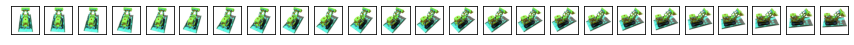

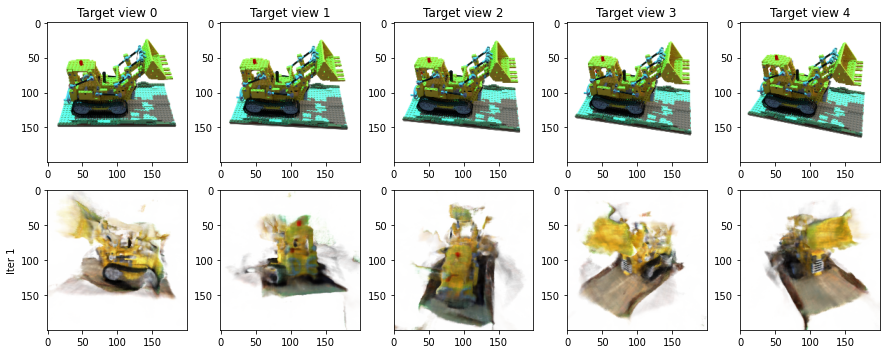

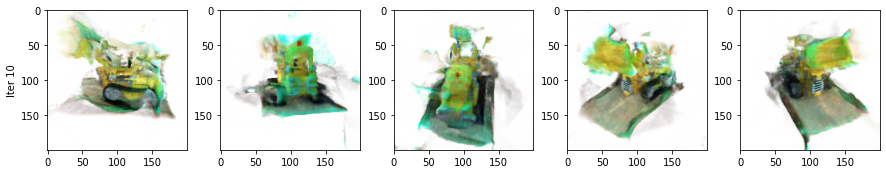

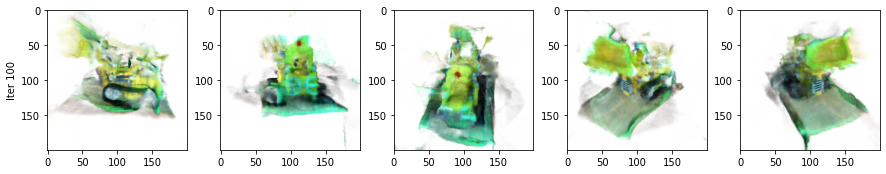

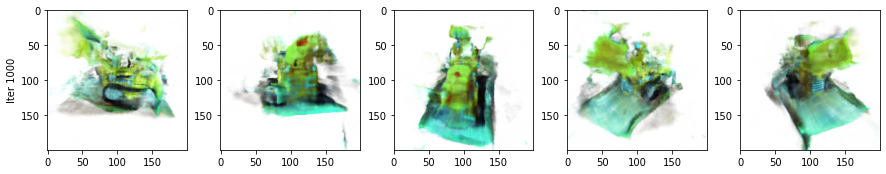

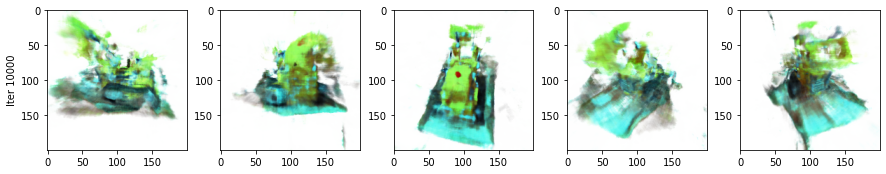

In [54]:
def psnr(gt, pred):
    assert gt.shape == pred.shape
    mse = np.mean((gt-pred)**2)
    psnr = -10 * np.log10(mse)
    return psnr

from time import time
max_iters = [1, 10, 100, 1000, 10000]
num_views = 25 # How many views to test-time optimize over
image_idx = 0
lr= 0.5
timesave = []

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))


for i in range(len(max_iters)):
    prevtime = time()
    test_params, sup_images = train_single_model(max_iters[i], rng, num_views=num_views, lr=lr, init_params=params, image_idx=image_idx)
    timesave.append(time()-prevtime)
    
    images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[2], type="train", down=4)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if i==0:
        if num_views>=5:
            plt.figure(figsize=(15,3))
        else:
            plt.figure(figsize=(3*num_views,3))
        for k in range(num_views):
            plt.subplot(1,num_views,k+1)
            plt.imshow(images[k])
            if k==0:
                plt.ylabel('Input Image')
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        plt.show()
    
    plt.figure(figsize=(15,3*(1+len(max_iters))))
    test_psnr = []
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        if i==0:
            plt.subplot(1+len(max_iters),5,j+1)
            plt.imshow(test_images[j])
            plt.title('Target view '+str(j))
        plt.subplot(1+len(max_iters),5,j+(i+1)*5+1)
        plt.imshow(test_result)
        if j==0:
            plt.ylabel('Iter '+str(max_iters[i]))
        
        test_psnr.append(psnr(test_images[j], test_result))
    # plt.show()
    # test_psnr.append(np.mean(np.array(test_psnr)))
    # print(test_psnr)
    # print("Time: ", timesave)
plt.show()